# Label numériques des écoles
## Exploration des données

On charge d'abord les différentes librairies qui nous seront utiles pour manipuler les données

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import plotly.express as px
from pandas.plotting import scatter_matrix
import numpy as np

In [25]:
dataset = pd.read_csv("../data/ecole/csv/fr-en-occitanie-ac-montpellier-label-numerique-ecoles.csv", sep=";")

#Renommage des colonnes
old_columns_names = dataset.columns.values
new_columns_names = {}

for old_name in old_columns_names:
    new_name = old_name.replace(" ", "_").lower()
    new_columns_names[old_name] = new_name

dataset = dataset.rename(columns=new_columns_names)

#Changer les indexs pour avoir une colonne "id" qui servira pour de futures jointures

dataset = dataset.set_index("uai")

#Transformer la colonne position en 2 colonnes latitude et longitude
dataset[["latitude", "longitude"]] = dataset["position"].str.split(",", expand=True)
dataset = dataset.drop(columns=["position"])


#Remplacer le nom de l'école par le nom de l'ecole plus le type, d'école et si c'est public ou privé
#Supprimer ce qui est inutile dans école


def transform(row):
    libelle_ecole = row.ecole.split(" ", 2)
    row["niveau"] = libelle_ecole[1].lower()
    nom_ecole = libelle_ecole[2].lower()
    second_split_try = nom_ecole.split(" ", 1)
    #On vérifie si ce qu'on a après le split est bien publique ou juste le nom de l'école
    if(second_split_try[0] == "publique"):
        #On verifie si on peut bien split, c'est a dire qu'on a plus que juste le mot publique ou bien chose après
        if(len(second_split_try) >= 2):
            nom_ecole = second_split_try[1]
        else:
            nom_ecole = "non renseigné"
    
    row["nom_ecole"] = nom_ecole
    return row
        
        
dataset = dataset.apply(lambda row: transform(row), axis=1)
#dataset = dataset.drop(columns=["ecole"])

dataset.niveau_label.astype("int64")

uai
0110161R    1
0110173D    1
0110256U    1
0300473B    1
0300632Z    1
           ..
0110427E    3
0301351F    3
0340803N    3
0480253P    3
0660393U    3
Name: niveau_label, Length: 155, dtype: int64

On va commencer par voir les différentes colonnes qui existent

In [26]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 0110161R to 0660393U
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   niveau_label  155 non-null    int64  
 1   commune       155 non-null    object 
 2   ecole         155 non-null    object 
 3   nbr_classes   155 non-null    float64
 4   latitude      155 non-null    object 
 5   longitude     155 non-null    object 
 6   niveau        155 non-null    object 
 7   nom_ecole     155 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 15.0+ KB
None


On va voir ensuite quels sont les proportions des différents labels

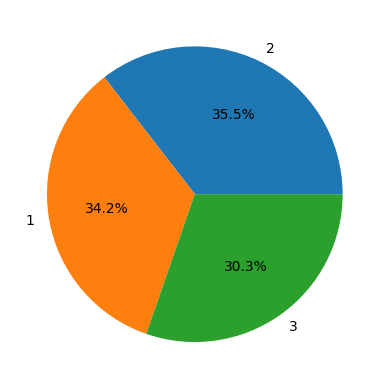

In [27]:
sizes = dataset.niveau_label.value_counts()

plt.pie(sizes, labels=sizes.index.values, autopct='%1.1f%%')
plt.show()

- On peut voir qu'il y a une répartition assez équilibrée des labels. On voit quand même un tiers des écoles qui ont un label ont un label de niveau 3
- Il faudrait penser à comparer avec le nombre total d'écoles sur l'occitanie pour voir si ce pourcentage est élevé ou pas

On va maintenant s'intéresser à quel niveau on a le plus d'établissement engagés dans ces démarches

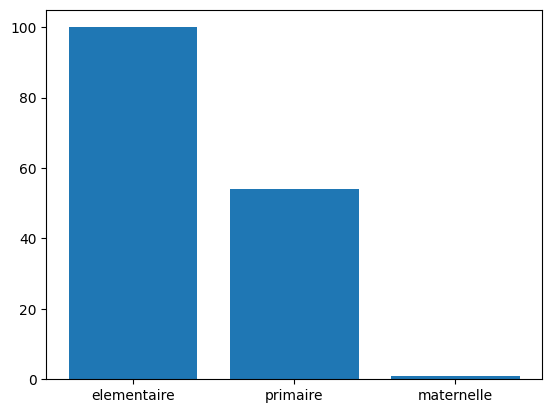

In [28]:
ecoles = dataset.niveau.value_counts()
y_pos = range(len(ecoles.index.values))

plt.bar(y_pos, ecoles.values)
plt.xticks(y_pos, ecoles.index.values)
plt.show()

On peut voir qu'il y a une minorité d'école maternelle.

In [29]:
print(dataset.loc[dataset.niveau == "maternelle"].niveau.count())

1


On voit bien qu'il n'y a qu'une seule école maternelle à avoir un label numérique.
Seul soucis : 
  - C'est qu'on a quand même un grand nombre d'écoles pour lesquelles on ne sait pas si c'est du élémentaire ou de la maternelle

In [30]:
m = folium.Map(location=[float(dataset.latitude[0]), float(dataset.longitude[0])], zoom_start=12, tiles="Stamen Terrain", height=500, width="100%")

for i in range(len(dataset)):
    color = "green" if dataset.niveau[i] == "maternelle" else "blue" if dataset.niveau[i] == "primaire" else "red"
    folium.Marker([float(dataset.latitude[i]), float(dataset.longitude[i])], popup=dataset.ecole[i], tooltip="See school", icon=folium.Icon(color = color, icon="school", prefix="fa")).add_to(m)

m

On va essayer de voir si il existe des liens entre les différentes variables. pour cela, on utilise la matrice de corrélation pour les variables numériques, qui sont le nombre de classe et le label numérique.

              niveau_label  nbr_classes
niveau_label      1.000000    -0.268604
nbr_classes      -0.268604     1.000000


<AxesSubplot:xlabel='nbr_classes', ylabel='niveau_label'>

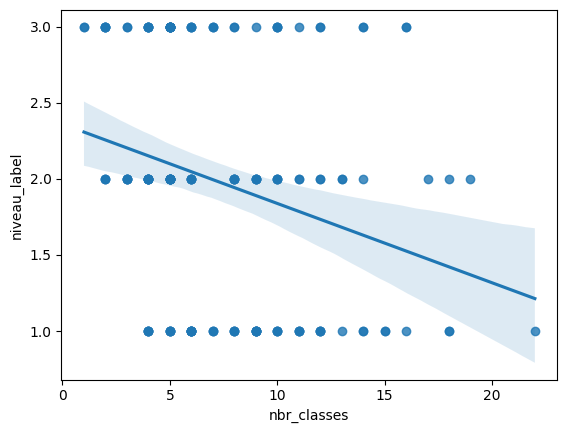

In [31]:
corr_matrix = dataset.corr()
print(corr_matrix)

sns.regplot(data=dataset, x="nbr_classes", y="niveau_label")

On voit qu'il n'y a absolument aucun lien entre le nombre de classes et le label

array([[<AxesSubplot:xlabel='niveau_label', ylabel='niveau_label'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='niveau_label'>],
       [<AxesSubplot:xlabel='niveau_label', ylabel='nbr_classes'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='nbr_classes'>]],
      dtype=object)

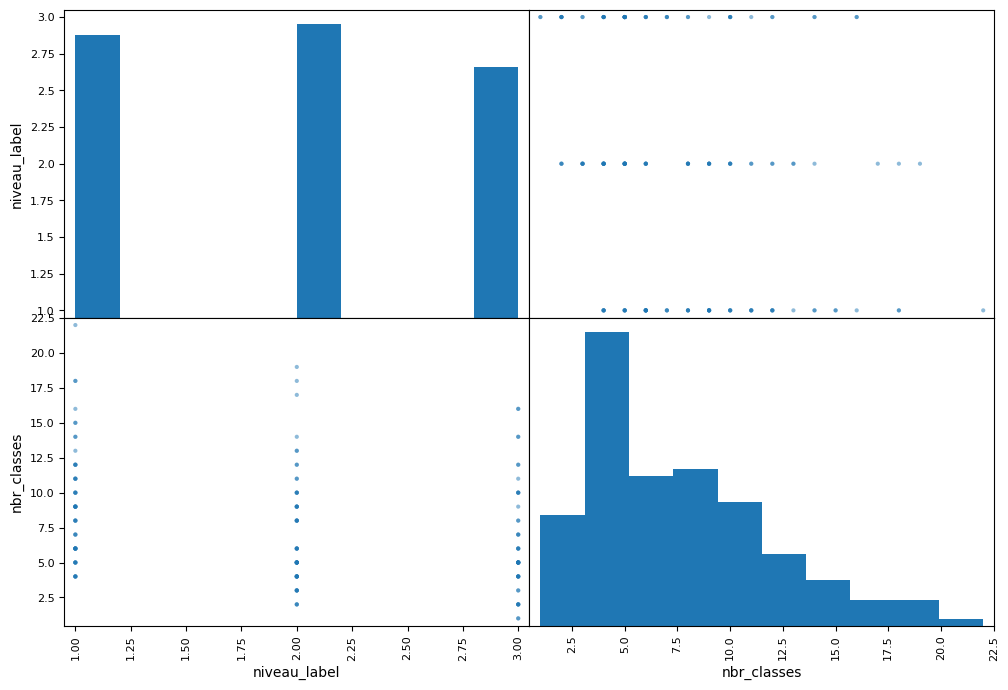

In [32]:


scatter_matrix(dataset, figsize=(12, 8))

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
from sklearn.decomposition import FactorAnalysis

transformer = FactorAnalysis(n_components=7, random_state=0)


## Un deuxième jeu de données

On récupére le jeu de données recu sur les TNE pour l'explorer et voir ce qu'il contient

In [35]:
dataset2 = pd.read_excel("../data/ecole/csv/Etablissements-scolaires-du-TNE-34.xlsx")

#Affectation des bons noms de colonnes
column_names = dataset2.loc[1]
dataset2 = dataset2.loc[2:]
dataset2 = dataset2.rename(columns=column_names)

print(dataset2.shape)
print(dataset2.columns.values)

(37, 3)
['Communes' 'Nom' 'UAI']


Ce jeu de données ne contient rien d'intéressant

## Un troisième jeu de données

Ce jeu de données contient les IPS des différentes écoles

In [36]:
#Récupération du jeu de données
dataset_ips = pd.read_csv("../data/ecole/csv/fr-en-ips_ecoles.csv", sep=";")

#Nettoyage des données

new_columns_names = {"UAI": "uai", "Rentrée scolaire":"annee", "Académie": "academie", "Code du département": "code_depart", "Département" : "departement", "Secteur":"secteur", "IPS":"ips"}

dataset_ips.rename(columns=new_columns_names, inplace=True)
dataset_ips = dataset_ips.set_index("uai")

dataset_ips = dataset_ips.drop(columns=["Code INSEE de la commune", "Nom de la commune", "Nom de l'établissment", "Code INSEE de la commune"])

dataset.drop(columns=["ecole", "nom_ecole"])


#Jointure des 2 datasets

join = dataset.join(dataset_ips, how="right", lsuffix="_ecole", rsuffix="_ips", on="uai")

#On supprime les lignes qui n'ont pas de niveau
join = join.loc[pd.notna(join.niveau_label)]


On va chercher si il y a une corrélation entre l'IPS et le Niveau label

              niveau_label  nbr_classes       ips
niveau_label      1.000000    -0.266718  0.135109
nbr_classes      -0.266718     1.000000 -0.411166
ips               0.135109    -0.411166  1.000000


array([[<AxesSubplot:xlabel='niveau_label', ylabel='niveau_label'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='niveau_label'>,
        <AxesSubplot:xlabel='ips', ylabel='niveau_label'>],
       [<AxesSubplot:xlabel='niveau_label', ylabel='nbr_classes'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='nbr_classes'>,
        <AxesSubplot:xlabel='ips', ylabel='nbr_classes'>],
       [<AxesSubplot:xlabel='niveau_label', ylabel='ips'>,
        <AxesSubplot:xlabel='nbr_classes', ylabel='ips'>,
        <AxesSubplot:xlabel='ips', ylabel='ips'>]], dtype=object)

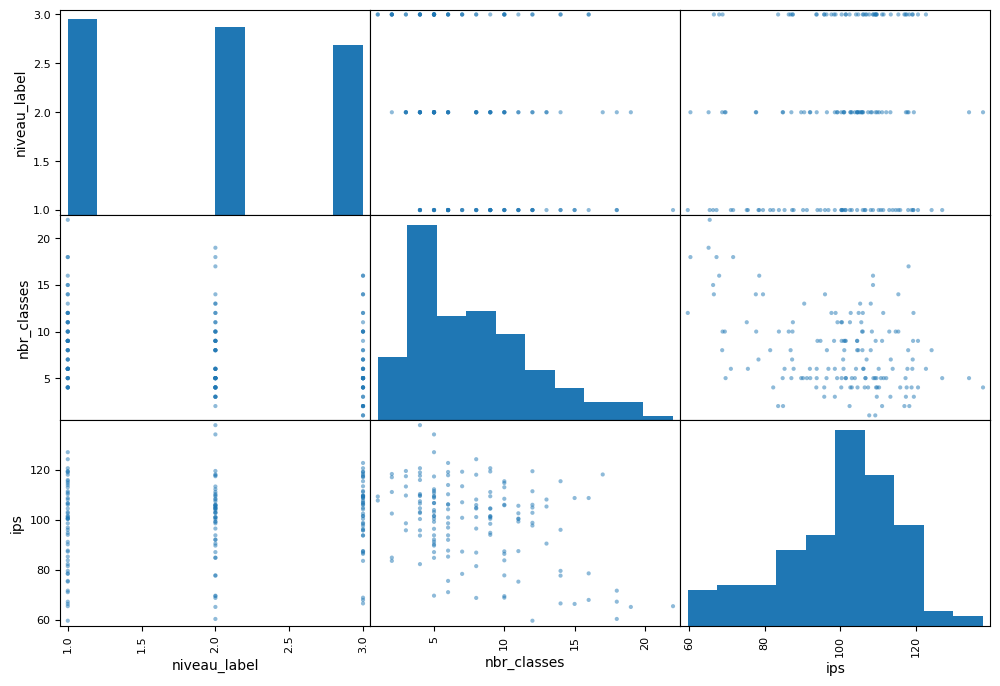

In [37]:
corr_matrix = join.corr()

print(corr_matrix)

scatter_matrix(join, figsize=(12, 8))

Grace à la matrice de corrélation, nous pouvons voir que le lien est très faible entre le niveau du Label Numérique et l'IPS d'un établissement. Il n'y a pas donc de lien entre la richesse des étudiants et le label.

In [38]:
print(join.niveau_label.dtype)
print(join.ips.dtype)
join.latitude = join.latitude.astype("float64")
join.longitude = join.longitude.astype("float64")
join.niveau_label = join.niveau_label.astype("int64")
print(join.latitude.dtype)

join['size'] = join.niveau_label * 10

float64
float64
float64


In [39]:


fig = px.scatter_mapbox(join, lat="latitude", lon="longitude", 
            color="ips" ,size="size" , color_continuous_scale=px.colors.diverging.Spectral_r, 
            hover_name="ecole", zoom=10, mapbox_style="open-street-map")
fig.show()

Les données sont assez homogénes, on remarque seulement que dans le Sud, l'IPS est plus bas qu'au Nord. On remarque cependant que dans le Nord, il y a de forts contrastes, les valeurs sont assez hétérogènes.

Les données ne sont pas trop exploitables. On va chercher une autre source de données qui est l'effectif des écoles d'éléves et par niveau.

## Effectifs

On va d'abord recueillir ces données et les explorer. Pour finir, on les joindra aux autres données pour essayer de trouver un lien

In [40]:
#Load the data
dataset_eff = pd.read_csv("../data/ecole/csv/fr-en-ecoles-effectifs-nb_classes.csv", sep=";")

#Some infos
dataset_eff.info()

dataset_eff.head()

print(dataset_eff.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13656 entries, 0 to 13655
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Rentrée scolaire                              13656 non-null  int64 
 1   Région académique                             13656 non-null  object
 2   Académie                                      13656 non-null  object
 3   Département                                   13656 non-null  object
 4   Commune                                       13656 non-null  object
 5   Numéro de l'école                             13656 non-null  object
 6   Dénomination principale                       13656 non-null  object
 7   Patronyme                                     8187 non-null   object
 8   Secteur                                       13656 non-null  object
 9   REP                                           13656 non-null  int64 
 10

In [41]:
#Some cleanings

dataset_eff = dataset_eff.drop(columns=["tri", "Code Postal", "Nombre d'élèves en ULIS", "REP", "REP +", "Patronyme", "Région académique", "Commune", "Département", "Académie", "Secteur"])

dataset_eff.info()

new_names_columns = {}

for column in dataset_eff.columns:
    new_name = column.lower().replace(" ", "_")
    new_name = new_name.replace("é", "e")
    new_name = new_name.replace("è", "e")
    new_name = new_name.replace("nombre", "nbr")
    new_name = new_name.replace("total", "tot")
    new_name = new_name.replace("d'eleves", "eleves")
    new_name = new_name.replace("_en", "")
    new_name = new_name.replace("_de", "")
    new_name = new_name.replace("_hors_ulis", "")
    new_names_columns[column] = new_name

dataset_eff.rename(columns=new_names_columns, inplace=True)
dataset_eff.rename(columns={"numero_l'ecole": "uai", "rentree_scolaire":"annee_effectifs", "denomination_principale" : "nom_ecole"}, inplace=True)

#Set the good index
dataset_eff = dataset_eff.set_index("uai")


print(dataset_eff.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13656 entries, 0 to 13655
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Rentrée scolaire                              13656 non-null  int64 
 1   Numéro de l'école                             13656 non-null  object
 2   Dénomination principale                       13656 non-null  object
 3   Nombre total de classes                       13656 non-null  int64 
 4   Nombre total d'élèves                         13656 non-null  int64 
 5   Nombre d'élèves en pré-élémentaire hors ULIS  13656 non-null  int64 
 6   Nombre d'élèves en élémentaire hors ULIS      13656 non-null  int64 
 7   Nombre d'élèves en CP hors ULIS               13656 non-null  int64 
 8   Nombre d'élèves en CE1 hors ULIS              13656 non-null  int64 
 9   Nombre d'élèves en CE2 hors ULIS              13656 non-null  int64 
 10

In [42]:
dataset_eff.head()

,annee_effectifs,nom_ecole,nbr_tot_classes,nbr_tot_eleves,nbr_eleves_pre-elementaire,nbr_eleves_elementaire,nbr_eleves_cp,nbr_eleves_ce1,nbr_eleves_ce2,nbr_eleves_cm1,nbr_eleves_cm2
uai,,,,,,,,,,,
0110069R,2021,ECOLE PRIMAIRE PUBLIQUE,2,32,23,9,9,0,0,0,0
0111042Y,2021,ECOLE ELEMENTAIRE PUBLIQUE,1,14,0,14,0,0,5,9,0
0110072U,2021,ECOLE ELEMENTAIRE PUBLIQUE,1,16,0,16,0,4,6,3,3
0110073V,2021,ECOLE PRIMAIRE PUBLIQUE,5,106,45,61,16,6,11,17,11
0110817D,2021,ECOLE PRIMAIRE PUBLIQUE,2,25,9,16,4,1,4,4,3


On va maintenant étudier ces données après les avoir nettoyées

<AxesSubplot:xlabel='annee_effectifs', ylabel='nbr_tot_classes'>

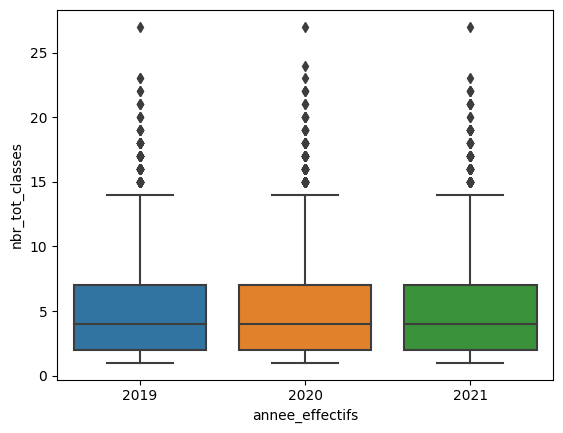

In [43]:
sns.boxplot(data=dataset_eff, x="annee_effectifs", y="nbr_tot_classes")

<AxesSubplot:xlabel='annee_effectifs', ylabel='nbr_tot_eleves'>

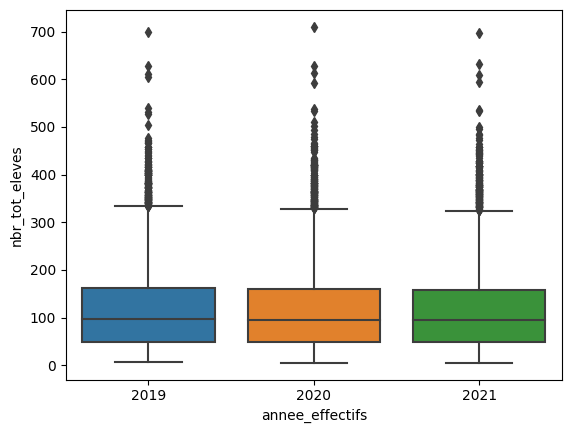

In [44]:
sns.boxplot(data=dataset_eff, x="annee_effectifs", y="nbr_tot_eleves")

On voit qu'entre les différentes années, on a toujours autant de classes et d'élèves, cela ne varie pas beaucoup dans la totalité

In [45]:
sns.boxplot(data=dataset_eff, x="annee_effectifs", y="nbr_tot_eleves", hue="regime")

ValueError: Could not interpret input 'regime'

On va créer un barPlot qui va permettre de connaitre le nombre de classe pour chaque filières chaque année

                 nbr_tot_classes  nbr_tot_eleves  nbr_eleves_pre-elementaire  \
annee_effectifs                                                                
2019                    5.192771      118.247755                   42.698795   
2020                    5.254997      117.009005                   41.586646   
2021                    5.280300      116.295284                   41.094976   

                 nbr_eleves_elementaire  nbr_eleves_cp  nbr_eleves_ce1  \
annee_effectifs                                                          
2019                          74.594085      14.660022       14.912815   
2020                          74.412036      14.599605       14.703931   
2021                          74.132658      14.485236       14.722785   

                 nbr_eleves_ce2  nbr_eleves_cm1  nbr_eleves_cm2  
annee_effectifs                                                  
2019                  15.003505       14.934721       15.083023  
2020                  15.01317

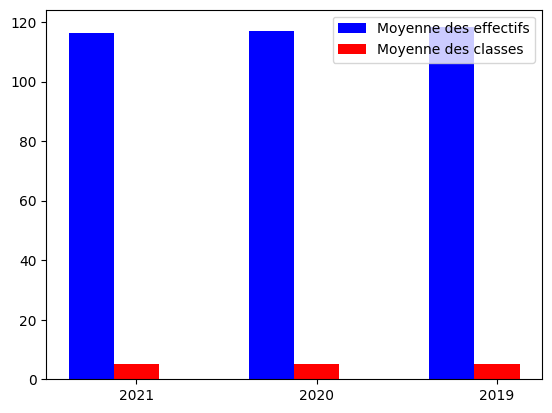

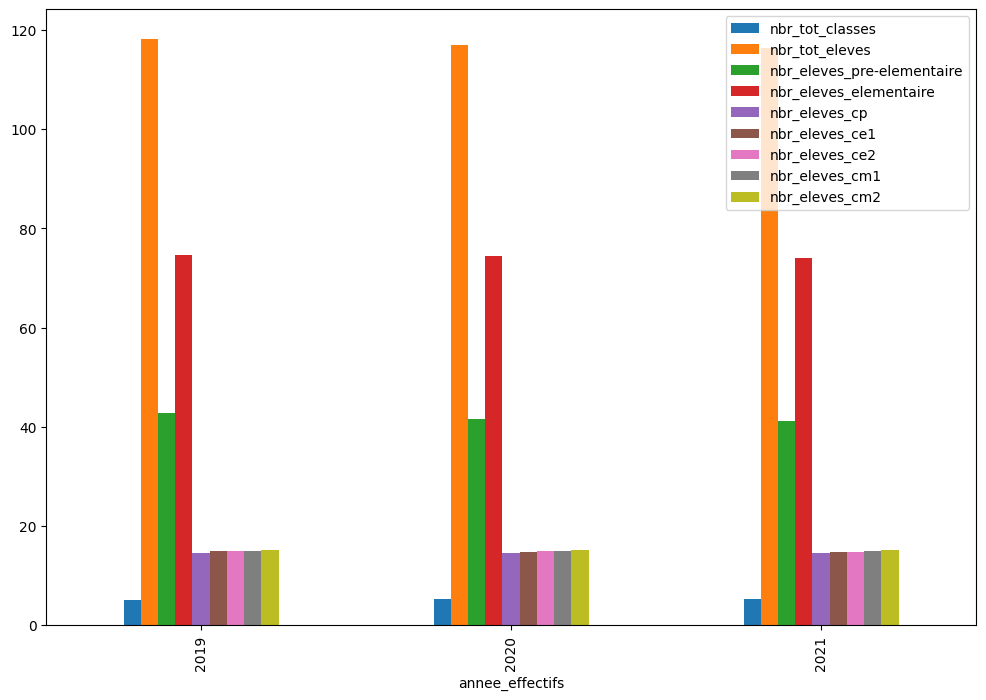

In [ ]:
#width of the bars
barWidth = 0.25

years = dataset_eff.annee_effectifs.unique()

values_eleves = {}

for year in years:
    values_eleves[year] = dataset_eff.loc[dataset_eff.annee_effectifs == year].nbr_tot_eleves.mean()

r1 = np.arange(len(values_eleves))
r2 = [x + barWidth for x in r1]

plt.bar(r1, values_eleves.values(), width=barWidth, label="Moyenne des effectifs", color="blue")



values_classes = {}

for year in years:
    values_classes[year] = dataset_eff.loc[dataset_eff.annee_effectifs == year].nbr_tot_classes.mean()

plt.bar(r2, values_classes.values(), width=barWidth, label="Moyenne des classes", color="red")
plt.xticks([r + barWidth for r in range(len(values_eleves))], values_eleves.keys())
plt.legend()


dataset_eff.groupby("annee_effectifs").mean().plot(kind="bar", figsize=(12, 8))

print(dataset_eff.groupby("annee_effectifs").mean())





On va voir si il existe un lien entre les différentes variables

In [ ]:
dataset_eff.corr()

,annee_effectifs,nbr_tot_classes,nbr_tot_eleves,nbr_eleves_pre-elementaire,nbr_eleves_elementaire,nbr_eleves_cp,nbr_eleves_ce1,nbr_eleves_ce2,nbr_eleves_cm1,nbr_eleves_cm2
annee_effectifs,1.000000,0.009400,-0.008818,-0.013255,-0.002129,-0.003966,-0.004269,-0.003855,0.000221,0.001451
nbr_tot_classes,0.009400,1.000000,0.965003,0.201543,0.856149,0.829005,0.831446,0.829466,0.820603,0.819344
nbr_tot_eleves,-0.008818,0.965003,1.000000,0.282087,0.850081,0.818190,0.820345,0.824411,0.819109,0.818267
nbr_eleves_pre-elementaire,-0.013255,0.201543,0.282087,1.000000,-0.264517,-0.237039,-0.253508,-0.263688,-0.261993,-0.259158
nbr_eleves_elementaire,-0.002129,0.856149,0.850081,-0.264517,1.000000,0.952778,0.964040,0.973718,0.967563,0.965076
nbr_eleves_cp,-0.003966,0.829005,0.818190,-0.237039,0.952778,1.000000,0.940066,0.906649,0.878916,0.873057
nbr_eleves_ce1,-0.004269,0.831446,0.820345,-0.253508,0.964040,0.940066,1.000000,0.922402,0.897708,0.891633
nbr_eleves_ce2,-0.003855,0.829466,0.824411,-0.263688,0.973718,0.906649,0.922402,1.000000,0.934023,0.933068
nbr_eleves_cm1,0.000221,0.820603,0.819109,-0.261993,0.967563,0.878916,0.897708,0.934023,1.000000,0.954068
nbr_eleves_cm2,0.001451,0.819344,0.818267,-0.259158,0.965076,0.873057,0.891633,0.933068,0.954068,1.000000


array([[<AxesSubplot:xlabel='annee_effectifs', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_tot_classes', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_tot_eleves', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_eleves_pre-elementaire', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_eleves_elementaire', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_eleves_cp', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_eleves_ce1', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_eleves_ce2', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_eleves_cm1', ylabel='annee_effectifs'>,
        <AxesSubplot:xlabel='nbr_eleves_cm2', ylabel='annee_effectifs'>],
       [<AxesSubplot:xlabel='annee_effectifs', ylabel='nbr_tot_classes'>,
        <AxesSubplot:xlabel='nbr_tot_classes', ylabel='nbr_tot_classes'>,
        <AxesSubplot:xlabel='nbr_tot_eleves', ylabel='nbr_tot_classes'>,
        <AxesSubplot:xlabel

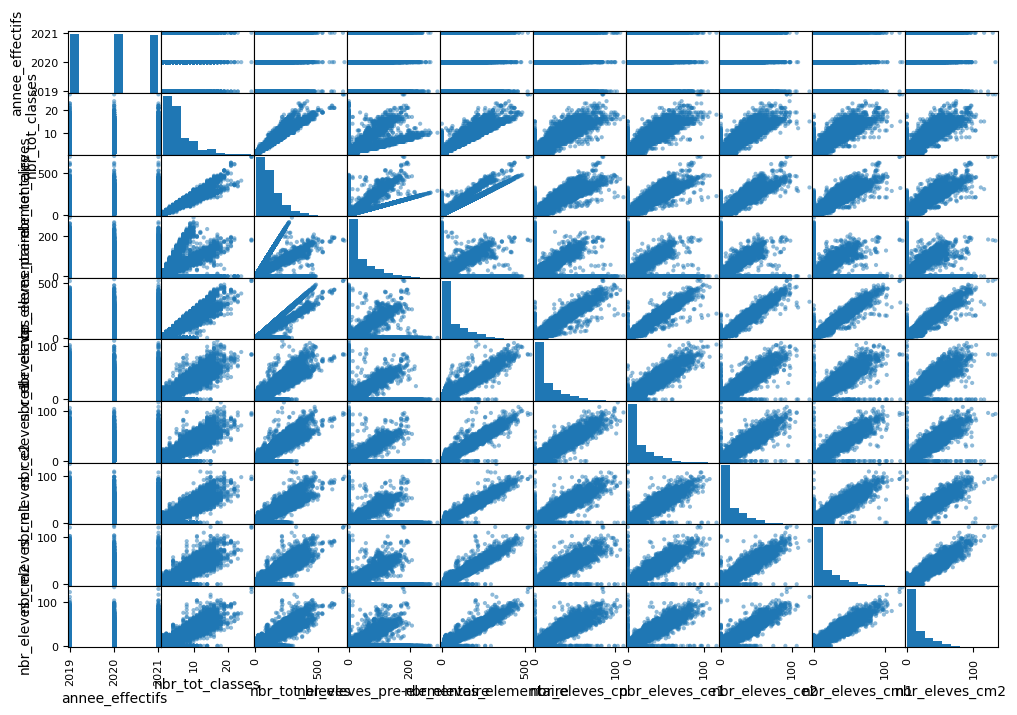

In [ ]:
scatter_matrix(dataset_eff, figsize=(12, 8))

-> On voit que les données sont fortement correlées, ce qui est normal car environ le même nombre de personnes se trouve à un niveau et se retrouve également au niveau supérieur. Il n'y a pas un grand nombre d'échecs.

#### Croisement des données

On va procéder maintenant au croisement des données.

In [ ]:
join_2 = dataset_eff.join(join, how="right", lsuffix="_eff", rsuffix="_ecole", on="uai")
join_2 = join_2.drop(columns=["size"])
print(join_2.columns)

Index(['annee_effectifs', 'nom_ecole_eff', 'nbr_tot_classes', 'nbr_tot_eleves',
       'nbr_eleves_pre-elementaire', 'nbr_eleves_elementaire', 'nbr_eleves_cp',
       'nbr_eleves_ce1', 'nbr_eleves_ce2', 'nbr_eleves_cm1', 'nbr_eleves_cm2',
       'uai', 'niveau_label', 'commune', 'ecole', 'nbr_classes', 'latitude',
       'longitude', 'niveau', 'nom_ecole_ecole', 'annee', 'academie',
       'code_depart', 'departement', 'secteur', 'ips'],
      dtype='object')


In [ ]:
join_2.corr()


,annee_effectifs,nbr_tot_classes,nbr_tot_eleves,nbr_eleves_pre-elementaire,nbr_eleves_elementaire,nbr_eleves_cp,nbr_eleves_ce1,nbr_eleves_ce2,nbr_eleves_cm1,nbr_eleves_cm2,niveau_label,nbr_classes,latitude,longitude,ips
annee_effectifs,1.000000e+00,0.008627,-0.020817,-0.003543,-0.018423,-0.020779,-0.019201,-0.025434,-0.024400,0.001693,3.299710e-14,-7.974717e-15,7.895489e-14,2.704945e-14,3.735617e-15
nbr_tot_classes,8.626831e-03,1.000000,0.926385,-0.073498,0.891501,0.864115,0.863059,0.856226,0.819436,0.834499,-2.657542e-01,9.946340e-01,-4.201901e-02,2.443107e-01,-4.030491e-01
nbr_tot_eleves,-2.081656e-02,0.926385,1.000000,-0.040941,0.962206,0.915401,0.915963,0.926166,0.903655,0.911755,-2.749478e-01,9.223780e-01,-1.335152e-01,2.399063e-01,-2.159275e-01
nbr_eleves_pre-elementaire,-3.542542e-03,-0.073498,-0.040941,1.000000,-0.306647,-0.276402,-0.288576,-0.291444,-0.306935,-0.293839,1.293816e-02,-7.541057e-02,2.808939e-01,2.310573e-01,2.597489e-01
nbr_eleves_elementaire,-1.842254e-02,0.891501,0.962206,-0.306647,1.000000,0.946731,0.950362,0.961434,0.945099,0.948867,-2.578240e-01,8.883379e-01,-2.052818e-01,1.672940e-01,-2.601670e-01
nbr_eleves_cp,-2.077882e-02,0.864115,0.915401,-0.276402,0.946731,1.000000,0.909268,0.905562,0.838841,0.846896,-2.649154e-01,8.637874e-01,-2.020034e-01,1.621586e-01,-3.173857e-01
nbr_eleves_ce1,-1.920079e-02,0.863059,0.915963,-0.288576,0.950362,0.909268,1.000000,0.893157,0.864101,0.852409,-2.664286e-01,8.636690e-01,-2.108740e-01,1.452298e-01,-3.073189e-01
nbr_eleves_ce2,-2.543413e-02,0.856226,0.926166,-0.291444,0.961434,0.905562,0.893157,1.000000,0.875994,0.895510,-2.486544e-01,8.540370e-01,-2.042737e-01,1.531569e-01,-2.401069e-01
nbr_eleves_cm1,-2.440017e-02,0.819436,0.903655,-0.306935,0.945099,0.838841,0.864101,0.875994,1.000000,0.911417,-2.169634e-01,8.142480e-01,-1.844677e-01,1.621820e-01,-1.790320e-01
nbr_eleves_cm2,1.692831e-03,0.834499,0.911755,-0.293839,0.948867,0.846896,0.852409,0.895510,0.911417,1.000000,-2.290286e-01,8.267342e-01,-1.747675e-01,1.717291e-01,-1.945599e-01


On ne trouve encore aucun lien qui pourrait expliquer quoique ce soit. Il n'y a donc pas de lien entre le nombre d'élèves dans une école et son label car on aurait pu penser que plus il y a d'étudiants et plus il y a de classes, alors plus une école s'engage dans le label numérique. Mais aucun lien 

## Analyse du nombre d'établissement qui ont un label numérique en France

On posséde la liste des établissements qui participe au projet Label numérique, mais on ne sait pas quelle importance cela a sur le niveau national car les établissements qui n'y participent pas n'apparaissent pas dans la liste.

- On va récupérer l'annuaire de toutes les écoles

In [ ]:
#Importer le fichier
dataset_annuaire = pd.read_csv("../data/ecole/csv/fr-en-annuaire-education.csv", sep=";")

#On renomme les colonnes pour avoir des noms plus simples
new_names_columns = {}

for column in dataset_annuaire.columns:
    new_names_columns[column] = column.lower().replace(" ", "_")

dataset_annuaire.rename(columns=new_names_columns, inplace=True)
dataset_annuaire.rename(columns={"identifiant_de_l_etablissement":"uai"}, inplace=True)

#Fixer l'index
dataset_annuaire.set_index("uai", inplace=True)

print(dataset_annuaire.type_etablissement.value_counts())

#On garde que les écoles car le reste ne nous sert pas ici
dataset_annuaire = dataset_annuaire.loc[dataset_annuaire.type_etablissement == "Ecole"]

#print(dataset_annuaire.info())


#On garde que les colonnes intéressantes
dataset_annuaire = dataset_annuaire.loc[:,["nom_etablissement", "latitude", "longitude", "coordonnee_x", "coordonnee_y", "nombre_d_eleves"]]

#print(dataset_annuaire.columns)


#Préparation du dataset 1
#print(dataset.columns)
#dataset = dataset.drop(columns=["commune", "nbr_classes", "latitude", "longitude", "nom_ecole"])

#Jointure des 2 datasets
join_3 = dataset_annuaire.join(dataset, how="left", lsuffix="_annuaire", rsuffix="_ecole", on="uai")

#Remplacer par 0 les valeurs manquantes du label numérique
join_3.niveau_label.fillna(0, inplace=True)


Ecole                         4633
Collège                        643
Lycée                          565
Service Administratif          148
Médico-social                  108
Information et orientation      38
EREA                             5
Name: type_etablissement, dtype: int64


([<matplotlib.patches.Wedge at 0x216212223b0>],
 [Text(-2.0206672185931328e-16, -1.1, '0.0')],
 [Text(-1.1021821192326178e-16, -0.6, '100.0%')])

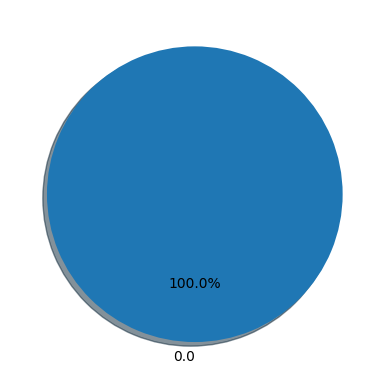

In [ ]:
sizes = join_3.niveau_label.value_counts()

plt.pie(sizes, labels=sizes.index, autopct='%1.1f%%', shadow=True, startangle=90)

In [ ]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=12)

for index, row in dataset_annuaire.iterrows():
    if row.niveau_label == 0:
        color = "red"
    elif row.niveau_label == 1:
        color = "blue"
    elif row.niveau_label == 2:
        color = "green"
    else:
        color = "black"
    folium.CircleMarker(location=[row.latitude, row.longitude], radius=5, color=color, fill=True).add_to(m)

m

NameError: name 'dataset_annuaire' is not defined